# Pushing particles (2-D)
Pushing particles around a mesh requires finding a good estimate of the eulerian velocity field on each particle location.

When interpolating onto particle points, we need to know which element each particle is inside of and the barycentric coordinates within that element. As input to such a method, we have 

1. `(xp,yp)` - the longitude and latitude of all particles
2. `(xv,yv,iv)` - mesh vertices and associated indices (also called `nod2d` in FESOM2)
3. `(ev)` - array of size `(1:nelem,1:3)` listing the element to vertex connectivity

To interpolate the mesh information onto the particle positions, we need to be able to identify the element each particle resides within. Once the element ID's are identified, computational coordinates / barycentric weights can be calculated and the `u` and `v` velocity components can be interpolated onto each point. If we are using an explicit time integration scheme, the particles can be advanced to new positions using the interpolated velocity fields. On the subsequent time step, we can check to see if each particle is still within the same element it was last seen in. If a particle is found in the same element, the computational coordinates can be re-calculated; if it is not, then we can search through the element neighbors to identify where the particle has gone to. In general, the algorithm looks like the following

* Initial element search. For each particle, determine the element ID it resides in
* Time loop
  * For each particle, calculate the barycentric weights (input: particle position, particle element IDs, element to vertex mapping )
  * For each particle, interpolate `u` and `v` onto particle positions (input: barycentric weights, particle element IDs, element to vertex mapping, u, v)
  * For each particle, update position
  * For each particle, update element IDs

## Initial element search
For an initial particle distribution, we need to perform a search to determine which element each particle resides in. When searching for the elements in a mesh that particles reside in for interpolation, efficiency and scalability are key. This becomes particularly important when simulating a large number of particles in a high-resolution grid or unstructured mesh. Here are some methods that scale well for finding elements in a mesh:

1. **Direct Grid Indexing (for Structured Grids)** : **\(O(1)\)** 
2. **Bounding Volume Hierarchies (BVH) (for Unstructured Meshes)** : Construction is **\(O(n \log n)\)**, and querying is **\(O(\log n)\)**, making it scalable for large meshes.
3. **KD-Trees (for General Geometries; commonly used in mesh free methods)** : Querying is **\(O(\log n)\)**
4. **Quadtrees** : Querying is **\(O(\log n)\)**
5. **Voronoi Diagrams** : Querying is **\(O(\log n)\)** *if a suitable search structure is employed (e.g., using a Voronoi graph or by combining with KD-tree/BVH structures)*. It’s more computationally expensive set up but can provide fast querying.
6. **Morton/Z-Order Curves (for Space-Filling Curves)** : Querying is **\(O(\log n)\)**; *Morton codes are particularly good for parallelization and GPU-based implementations.*
7. **Spatial Hashing (for Dynamic Particle Systems)** : Querying is **\(O(1)\)**; *Care is needed to avoid collisions and handle edge cases efficiently*

In Particle-In-Cell (PIC) simulations with **unstructured 2D triangular meshes**, determining which mesh element (triangle) a particle resides in is a critical step for accurate interpolation and force computation. **Spatial hashing** can be adapted to accelerate this process, even with the complexity of an unstructured mesh. The main challenge in this case is efficiently searching the large number of mesh elements (triangles) to find the one that contains a given particle, especially as the number of particles increases.

Here’s how spatial hashing can be applied in this context, along with an example.

## Spatial Hashing with an Unstructured 2D Triangular Mesh

1. **Divide the Space into Hash Cells**:
   - Although the underlying mesh is unstructured (i.e., made up of triangles of various shapes and sizes), the overall 2D simulation space can still be divided into a grid of square (or rectangular) **hash cells**. Each hash cell corresponds to a "bucket" in the hash table. Hash cells are typically defined by their lower left corner vertex and the cell size **($\Delta x$, $\Delta y$)**
   - Each triangle in the unstructured mesh is assigned to one or more hash cells based on its bounding box. This means that each hash cell contains a list of the triangles that overlap with it.

2. **Preprocessing: Assign Triangles to Hash Cells**:
   - For each triangle in the mesh, compute its **axis-aligned bounding box (AABB)**. This is the smallest rectangle that fully encloses the triangle, aligned with the coordinate axes.
   - Using the bounding box, determine which hash cells the triangle overlaps. This might involve checking multiple hash cells (for example, if the triangle spans several cells).
   - Store the triangle’s reference in each of the relevant hash cell buckets in the hash table. A good hash function (as described earlier) is used to map the coordinates of each hash cell to a hash key.

3. **Particle-to-Element Search**:
   - For each particle, compute the hash key of the cell that contains its position.
   - Check all the triangles associated with that hash cell (retrieved from the hash table).
   - For each triangle in the bucket, perform a **point-in-triangle test** to determine if the particle lies inside the triangle.

4. **Point-in-Triangle Test**:
   - For each triangle found in the hash cell, the particle’s position is tested using **barycentric coordinates** or other geometric tests to check whether the particle lies inside the triangle.
   - If the particle lies inside the triangle, it is assigned to that triangle for the purpose of interpolation.

5. **Handling Edge Cases**:
   - If the particle’s position is near a triangle edge or vertex, it may belong to multiple neighboring triangles. In such cases, you may need to apply additional logic to select the triangle or handle interpolation across multiple elements.

In 2D spatial hashing, **hash cells** are typically defined as rectangular or square regions of space. When defining the position of a hash cell, the reference point for computing the hash key can be either:

1. **The hash cell center**, or
2. **One of the four corner nodes** (usually the lower-left corner, but this can be flexible).

## Common Practice: Lower-Left Corner Node
The most common approach is to take **one of the corner nodes** (usually the **lower-left corner**) of the hash cell as the reference point for computing the hash key. This makes the hashing scheme straightforward and easy to compute, especially when working with regularly spaced grids.

### How It Works:
1. **Define the Hash Cell Size**: Suppose each hash cell has a size \(\Delta x \times \Delta y\).
   
2. **Compute the Hash Cell Coordinates**: For a particle at position \((x, y)\), the hash cell it belongs to is determined by calculating the integer coordinates of the hash cell's lower-left corner:
$i = \left\lfloor \frac{x}{\Delta x} \right\rfloor, \quad j = \left\lfloor \frac{y}{\Delta y} \right\rfloor$

where $\(\left\lfloor \cdot \right\rfloor\)$ represents the floor function, which rounds down to the nearest integer.
   
3. **Hash Key Computation**: A hash key is then computed based on these integer cell coordinates, often using a hash function like:
$\text{hash}(i, j) = (i \times p_1) \oplus (j \times p_2) \mod N $
   where $(p_1)$ and $(p_2)$ are large prime numbers, and $(N)$ is the size of the hash table.

By using the lower-left corner as the reference point, the calculation of which cell a particle belongs to is simple, consistent, and unambiguous. This approach is particularly useful when the simulation space is divided into uniform cells, making it easy to map a particle's coordinates directly to the hash cell.


### Benefits of Spatial Hashing in PIC with Unstructured Meshes

1. **Efficiency**: Without spatial hashing, determining the triangle that contains a particle in an unstructured mesh would involve checking every triangle, resulting in a complexity of **\(O(n)\)** per particle, where \(n\) is the number of triangles. Spatial hashing reduces this search to **\(O(1)\)** on average, significantly speeding up the simulation.
   
2. **Scalability**: By mapping the 2D simulation space to a grid, spatial hashing allows for fast querying and efficient handling of large numbers of particles in large meshes, which scales well as the mesh resolution increases.

3. **Parallelization**: The hash table construction and particle search process can be parallelized, allowing for efficient execution on multi-core processors or GPUs.

### Challenges

1. **Hash Cell Size**: Choosing an appropriate cell size is important. Cells that are too large may result in many triangles per cell, slowing down the search. Cells that are too small may increase the number of hash cells a triangle overlaps with, making the hash table more memory-intensive.
   
2. **Edge Cases**: Particles near triangle edges or vertices may require additional checks to handle ambiguity in determining the containing element.

Choosing the hash cell size for spatial hashing in an unstructured triangular mesh involves balancing between performance and accuracy. Here are some key considerations and strategies to help you select an appropriate hash cell size:

### Key Considerations for Hash Cell Size

1. **Triangle Size and Distribution**:
   - The hash cell size should be roughly comparable to the size of the triangles in the mesh. Since the mesh is unstructured, triangle sizes might vary, so an average or representative triangle size is often used.
   - If there is a significant variation in triangle sizes, you might consider an approach that adjusts hash cell sizes locally or opts for a smaller size to handle smaller triangles effectively.

2. **Particle Density and Movement**:
   - If the particles are densely packed and move only within a small area, you can use smaller hash cells, which will provide more localized results and reduce the number of triangles to check within each cell.
   - If particles move freely across the mesh, a larger hash cell size might be necessary to reduce the likelihood of particles frequently crossing cell boundaries and needing rehashing.

3. **Aspect Ratio of the Mesh**:
   - Triangular meshes might not be uniform, and the aspect ratio could vary in different areas. If triangles are elongated in one direction, consider orienting the hash cells to match the general orientation of triangles, though this adds complexity to the implementation.

### Strategies for Determining Hash Cell Size

1. **Using the Average Triangle Edge Length**:
   - Calculate the average length of all triangle edges in the mesh. This gives a sense of the general triangle size and can be a starting point for the hash cell size.
   - A common heuristic is to set the cell size to be **slightly larger than the average edge length**, which ensures that most triangles will fit within one or two hash cells.

2. **Using the Median Triangle Area**:
   - Compute the area of each triangle and take the median area to avoid being skewed by extremely large or small triangles. 
   - Convert the median area into an approximate length by assuming an equilateral triangle:
     \[
     \text{edge length} \approx \sqrt{\frac{4 \times \text{median area}}{\sqrt{3}}}
     \]
   - Use this length or a slightly larger value as the cell size.

3. **Trial and Error**:
   - Start with a cell size equal to the average triangle edge length, then incrementally adjust it based on performance. You can reduce the size if many hash cells contain numerous triangles, or increase it if too few cells contain multiple triangles.

4. **Bounding Box of Triangles**:
   - For each triangle, calculate its bounding box dimensions. Use an average or representative bounding box diagonal as a basis for the hash cell size. This approach can accommodate irregularly shaped triangles more effectively than edge length alone.

### Example Calculation for Hash Cell Size

Suppose you have a triangular mesh, and the average edge length of the triangles is approximately \( l \). As a rule of thumb, you might start with a hash cell size:
\[
\Delta x = \Delta y \approx 1.5 \times l
\]
This approach assumes that most triangles will fit within a cell or intersect only a few neighboring cells, which keeps the number of checks per particle low.

Alternatively, if the average triangle area is \( A \), you could approximate an equivalent side length as follows:
\[
l_{\text{equiv}} = \sqrt{\frac{4A}{\sqrt{3}}}
\]
Then set the cell size to:
\[
\Delta x = \Delta y \approx 1.5 \times l_{\text{equiv}}
\]

### Evaluating the Cell Size Choice

- **Profile Performance**: After selecting an initial cell size, evaluate the hashing performance by measuring the average number of triangles per hash cell and the frequency of particle rehashing.
- **Adjust Based on Hashing Results**: If hash cells often contain many triangles, reduce the cell size. If cells are mostly empty, increase the size to avoid unnecessary memory usage.

Selecting the right hash cell size will involve some tuning specific to your mesh's characteristics, but using these strategies should give you a practical starting point.

### Example Walkthrough - Simple 2-D Mesh

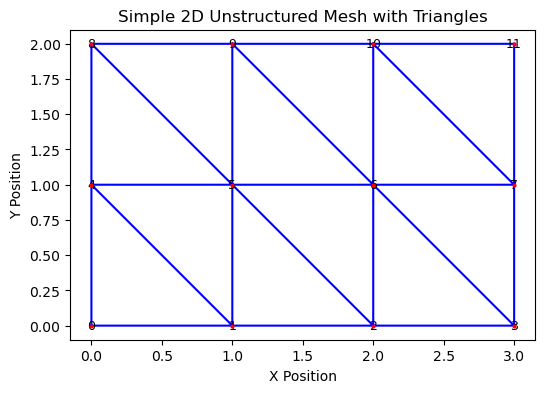

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def create_simple_2d_unstructured_mesh():
    """
    Generates a simple 2D unstructured triangular mesh with fewer than 30 triangles.
    
    Returns:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    """
    # Define the vertex coordinates (x, y)
    vertices = np.array([
        [0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [1, 1], [2, 1], [3, 1],
        [0, 2], [1, 2], [2, 2], [3, 2]
    ])
    
    # Define the triangle elements by specifying the vertex indices
    elements = np.array([
        [0, 1, 4], [1, 5, 4], [1, 2, 5], [2, 6, 5], [2, 3, 6], [3, 7, 6],
        [4, 5, 8], [5, 9, 8], [5, 6, 9], [6, 10, 9], [6, 7, 10], [7, 11, 10]
    ])
    
    return vertices, elements

# Generate the mesh
vertices, elements = create_simple_2d_unstructured_mesh()

# Plot the mesh
mesh = tri.Triangulation(vertices[:, 0], vertices[:, 1], elements)
plt.figure(figsize=(6, 6))
plt.triplot(mesh, color='blue', lw=1.5)
plt.scatter(vertices[:, 0], vertices[:, 1], color='red', zorder=5, s=4)

# Annotate the vertices
for i, (x, y) in enumerate(vertices):
    plt.text(x, y, str(i), color='black', ha='center', va='center', fontsize=9)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Simple 2D Unstructured Mesh with Triangles')
plt.gca().set_aspect('equal')
#plt.grid(True)
plt.show()


#### Creating the hash cells
Now we want to create the hash cells for spatial hashing. The hash cells are determined by their lower left vertex and their size. Since we are assuming at the moment the hash cells are isotropic and their size is constant in the mesh, we simply need to know the lower left vertex in the mesh and the cell size.

Here, the hash cell size is using a length that is proportional to the median diagonal length of the bounding box for each triangle. The `calculate_hash_cell_size` function takes in a list of vertices, the element connectivity, and a scale factor and returns the hash cell size. The hash cell size is the scale factor multiplied by the median element bounding box diagonal.

In [14]:
def calculate_hash_cell_size(vertices, elements, scalefac=1.0):
    """
    Calculate the hash cell size based on the median bounding box diagonal length of all triangles in the mesh.
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - scalefac (float): Multiplier for the median triangle diagonal length to set the hash cell size
    
    Returns:
    - cell_size (float): The recommended hash cell size.
    """
    import numpy as np
    
    # Initialize a list to store bounding box diagonals
    diagonals = np.zeros(elements.shape[0])

    # Loop over each triangle element
    k = 0
    for triangle in elements:
        # Get the coordinates of the triangle's vertices
        triangle_vertices = vertices[triangle]
        
        # Calculate the bounding box of the triangle
        x_min, y_min = np.min(triangle_vertices, axis=0)
        x_max, y_max = np.max(triangle_vertices, axis=0)
        
        # Calculate the diagonal length of the bounding box
        diagonal = np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)
        
        # Store the diagonal length
        diagonals[k] = diagonal

        k+=1
    
    print(f"Minimum diagonal : {np.min(diagonals)}")
    print(f"Maximum diagonal : {np.max(diagonals)}")
    print(f"Mean diagonal    : {np.mean(diagonals)}")
    print(f"Median diagonal  : {np.median(diagonals)}")
    
    # Use the median diagonal as a basis for the cell size
    cell_size = np.median(diagonals)*scalefac
    
    return cell_size

# Calculate hash cell size
hash_cell_size = calculate_hash_cell_size(vertices, elements,0.25)
print( f"Hash cell size : {hash_cell_size}")

Minimum diagonal : 1.4142135623730951
Maximum diagonal : 1.4142135623730951
Mean diagonal    : 1.4142135623730951
Median diagonal  : 1.4142135623730951
Hash cell size : 0.3535533905932738


Now that we have the hash cell size, we can visualize the unstructured grid with the hash cells overlayed.

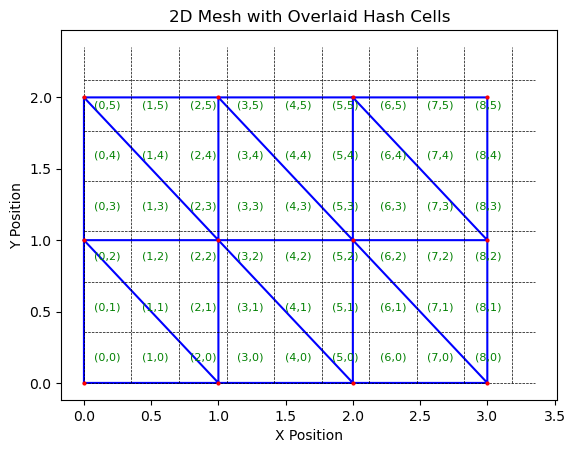

In [20]:
def plot_mesh_with_hash_cells(vertices, elements, cell_size, annotate=False):
    """
    Plots the unstructured mesh with overlaid hash cells.
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.tri as tri

    # Create a matplotlib Triangulation object for the mesh
    mesh = tri.Triangulation(vertices[:, 0], vertices[:, 1], elements)

    # Plot the mesh
    plt.figure()
    plt.triplot(mesh, color='blue', lw=1.5)
    plt.scatter(vertices[:, 0], vertices[:, 1], color='red', zorder=5, s=4)

    # Get the bounds of the mesh
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)

    # Generate and plot hash cells
    x_ticks = np.arange(x_min, x_max + cell_size, cell_size)
    y_ticks = np.arange(y_min, y_max + cell_size, cell_size)

    # Plot horizontal lines for hash cells
    for y in y_ticks:
        plt.plot([x_min, x_max+cell_size], [y, y], color='black', linestyle='--', lw=0.5)

    # Plot vertical lines for hash cells
    for x in x_ticks:
        plt.plot([x, x], [y_min, y_max+cell_size], color='black', linestyle='--', lw=0.5)

    if(annotate):
    # Annotate the hash cells (optional, could be cluttered with dense grids)
        for i, x in enumerate(x_ticks[:-1]):
            for j, y in enumerate(y_ticks[:-1]):
                plt.text(x + 0.5 * cell_size, y + 0.5 * cell_size, f"({i},{j})", 
                         fontsize=8, color='green', ha='center', va='center', zorder=10)

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('2D Mesh with Overlaid Hash Cells')
    #plt.gca().set_aspect('equal')
    plt.grid(False)
    plt.show()

# Plot the mesh with hash cells
plot_mesh_with_hash_cells(vertices, elements, hash_cell_size, annotate=True)

The figure above shows the unstructured grid elements (blue lines) and vertices (red dots) with the hash cells overlayed (dashed lines).

#### Relating the the unstructured mesh elements to the hash cells
Now that we have the hash cell size, we now want to create a lookup table where we can put in the hash cell indices `(i,j)` and retrieve a list of elements whose bounding boxes overlap the hash cells. This way, when we want to map the particle positions to the triangular element id's we can first do a fast lookup against the hash cells. Once we have the hash cell id for the particle position, we can get a short list of triangles that we can use to check if the particle resides in.



In [22]:
def get_triangles_in_hash_cells(nxh, nyh, vertices, elements, cell_size):
    """
    Efficiently find the list of triangles whose bounding box overlaps with the specified hash cells.
    
    Parameters:
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - overlapping_triangles (dict): A dictionary where keys are the hash cell index and values are lists of triangle indices.
    """
    import numpy as np
    
    overlapping_triangles = [[] for i in range(nxh*nyh)]
    
    # Loop over each triangle element
    for triangle_idx, triangle in enumerate(elements):
        # Get the coordinates of the triangle's vertices
        triangle_vertices = vertices[triangle]
        
        # Calculate the bounding box of the triangle
        x_min, y_min = np.min(triangle_vertices, axis=0)
        x_max, y_max = np.max(triangle_vertices, axis=0)
        
        # Find the hash cell range that overlaps with the triangle's bounding box
        i_min = int(np.floor(x_min / cell_size))
        i_max = int(np.floor(x_max / cell_size))
        j_min = int(np.floor(y_min / cell_size))
        j_max = int(np.floor(y_max / cell_size))
        
        # Iterate over all hash cells that intersect the bounding box
        for j in range(j_min, j_max + 1):
            for i in range(i_min, i_max + 1):
                overlapping_triangles[i+nxh*j].append(triangle_idx)
                    
    return overlapping_triangles


The hash cells are defined by their lower left corner and their size. Here, we are assuming the hash cells are squares. To create the hash cells, we first define the bounding box of the domain spanned by the unstructured mesh. From this and the hash cell size, we can determine the number of hash cells in the mesh. Since the hash cells are non-overlapping elements in a structured grid, we can easily generate a unique integer for each hash cell `idx = i + nxh*j` where `i` is the index in the `x` direction and `j` is the index in the `y` direction. This allows us to create a hash table that takes a unique integer `idx` and returns the list of elements that overlap the hash cell.

To make calculation of the `i` and `j` indices simple, the hash cell grid is assumed to have an origin at `(0,0)`. Consquently, the unstructured grid is shifted so that its origin is also at `(0,0)`.

When using spatial hashing to determine which unstructured element a particle resides in, we have to first map the particle to the hash cell. This is inexpensive since calculating `idx` is reduced to calculating `i = floor(xp / cell_size)` and `j = floor(xp / cell_size)`. Once we have the hash cell that the particle resides in, we then look through the list of elements associated with that hash cell and perform checks to determine which element the particle is in. This is typically done by calculating the barycentric coordinates for the particle and checking if this places the particle inside or outside the element. This is more computationally expensive than the hash cell lookup.

With this in mind, we want to get a feel for the number of triangular elements associated with each hash cell. After creating the hash table, the end of the code snippet below looks into the distribution of triangles per hash cell.

Domain size (Lx,Ly) : (3,2)
Number of hash cells (nxh,nyh) : (9,6)
Check min vertex position : [0 0]
Minimum triangle count per hash cell : 2.0
Maximum triangle count per hash cell : 8.0
Median triangle count per hash cell  : 2.0
Number of non-empty hash cells       : 54 ( 100.0 %)


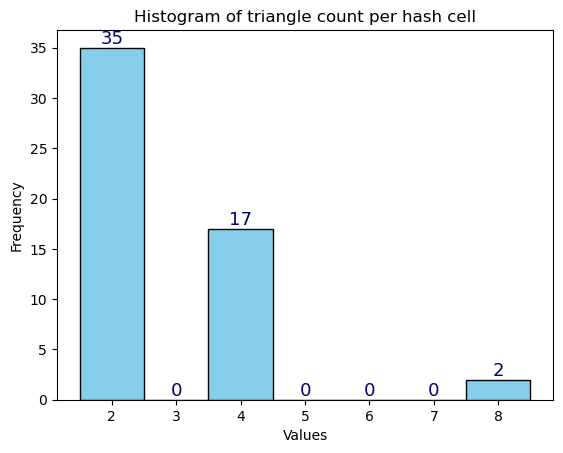

In [47]:
# Get the bounding box for the domain
x_min, y_min = np.min(vertices, axis=0)
x_max, y_max = np.max(vertices, axis=0)

# To determine how many hash cells we need, we divide the domain length by the hash_cell_size
Lx = (x_max-x_min)
Ly = (y_max-y_min)
print( f"Domain size (Lx,Ly) : ({Lx},{Ly})")
nxh = int(np.ceil(Lx/hash_cell_size))
nyh = int(np.ceil(Ly/hash_cell_size))
print( f"Number of hash cells (nxh,nyh) : ({nxh},{nyh})")

# The vertices are required to share an origin in the lower left corner with the hash map.
# Since the hash map is assumed to start at (0,0), then the vertices are translated so that
# the (x_min,y_min) = (0,0)
vertices[:,0] = vertices[:,0] - x_min
vertices[:,1] = vertices[:,1] - y_min
print(f"Check min vertex position : {np.min(vertices, axis=0)}")

triangles_hashmap = get_triangles_in_hash_cells(nxh,nyh,vertices,elements,hash_cell_size)

## Count how many triangles are in each hash cell.
hashmap_triangle_count = np.zeros(len(triangles_hashmap))
k=0
for t in triangles_hashmap:
    hashmap_triangle_count[k]=len(t)
    k+=1

nnonzero = np.count_nonzero(hashmap_triangle_count)
print(f"Minimum triangle count per hash cell : {np.min(hashmap_triangle_count)}")
print(f"Maximum triangle count per hash cell : {np.max(hashmap_triangle_count)}")
print(f"Median triangle count per hash cell  : {np.median(hashmap_triangle_count)}")
print(f"Number of non-empty hash cells       : {nnonzero} ( {nnonzero/len(triangles_hashmap)*100.0} %)")

# Plotting a basic histogram
bin_edges = np.arange( np.min(hashmap_triangle_count)-0.5, np.max(hashmap_triangle_count)+1.5,1)
values, bins, bars = plt.hist(hashmap_triangle_count, bins=bin_edges, color='skyblue', edgecolor='black',align='mid')
plt.bar_label(bars, fontsize=13, color='navy')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of triangle count per hash cell')
 
# Display the plot
plt.show()

For this simple example, we see that we have 9x6 (54) hash cells. The majority (35) of the hash cells are associated with two triangles. Some (17) are associated with 4 triangles, and two hash cells are associated with 8 triangles. From the plot above, with the hash cells overlayed on the triangular elements, we can see that hash cells `(2,2) and `(5,2)` each overlap with 8 triangles.

I would suppose that this distribution is ok, even if it is not "optimal", since the majority of the hash cells would incur at most two element checks in our particle to element search method.

#### Aligning the particles with a hash cell
Now that we have the hash map defined and we have associated a list of triangle elements with each hash cell, we can now start working on the search method to map a particle position to an element. The first step in this process is to map the particle position to the hash cell.

As mentioned previously, calculating the hash cell that each particle resides in is fairly straightforward. Given a list of `x` and `y` positions for particles, we can calculate `i = int(floor( x / cell_size ))` and `j = int(floor( y / cell_size ))`. To calculate the unique integer for the hash table lookup, we simply set the hash table id to `idx = i + nxh*j` for each particle. 



In [58]:
def get_particles_in_hash_cells(nxh, nyh, xp, yp, cell_size):
    """
    Efficiently map the particle positions to the hash
    
    Parameters:
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - xp (np.ndarray): Array of x component of the particle positions (length = np)
    - yp (np.ndarray): Array of y component of the particle positions (length = np)
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - particle_hash (np.ndarray(dtype=int)): Array of size (np) that stores the hash cell index for the particles
    """
    import numpy as np
    
    particle_hash = np.zeros(xp.size,dtype=int)

    for k in range(xp.size):
        i = int(np.floor(xp[k] / cell_size))
        j = int(np.floor(yp[k] / cell_size))
        particle_hash[k] = i+nxh*j
        
    return particle_hash


Now that we have the function for associating a hash table index with each particle, let's generate some particles and try it out. Here, we generate arrays for x and y positions of particles using a random uniform distribution of values between `[x_min,x_max]` and `[y_min,y_max]`. These positions are then passed into the `get_particles_in_hash_cells` function which returns an array that is of length `num_particles` and contains the hash cell id associated with each particle.



In [50]:
num_particles = 10
xp = np.zeros(num_particles)
yp = np.zeros(num_particles)
for k in range(num_particles):
    xp[k] = np.random.uniform(x_min, x_max)
    yp[k] = np.random.uniform(y_min, y_max)

We also plot the particle positions overlayed on the unstructured grid and the hash cells for reference

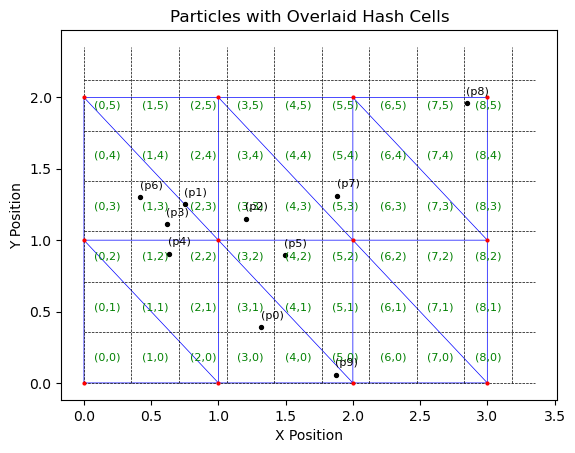

In [95]:
def plot_particles_with_mesh_and_hash_cells(vertices, elements, xp, yp, cell_size, plot_hash_cells=True, annotate_hash_cells=False, annotate_elements=False, annotate_particles=False):
    """
    Plots the particles with the unstructured mesh and hash cells.
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - xp (np.ndarray): Array of x component of the particle positions (length = np)
    - yp (np.ndarray): Array of y component of the particle positions (length = np)
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.tri as tri

    # Create a matplotlib Triangulation object for the mesh
    mesh = tri.Triangulation(vertices[:, 0], vertices[:, 1], elements)

    # Plot the mesh
    plt.figure()
    plt.triplot(mesh, color='blue', lw=0.5)
    plt.scatter(vertices[:, 0], vertices[:, 1], color='red', zorder=5, s=4)
    plt.scatter(xp, yp, color='k', zorder=5, s=8)

    # Get the bounds of the mesh
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)

    if plot_hash_cells :
        # Generate and plot hash cells
        x_ticks = np.arange(x_min, x_max + cell_size, cell_size)
        y_ticks = np.arange(y_min, y_max + cell_size, cell_size)
    
        # Plot horizontal lines for hash cells
        for y in y_ticks:
            plt.plot([x_min, x_max+cell_size], [y, y], color='black', linestyle='--', lw=0.5)
    
        # Plot vertical lines for hash cells
        for x in x_ticks:
            plt.plot([x, x], [y_min, y_max+cell_size], color='black', linestyle='--', lw=0.5)
    
        if(annotate_hash_cells):
        # Annotate the hash cells (optional, could be cluttered with dense grids)
            for i, x in enumerate(x_ticks[:-1]):
                for j, y in enumerate(y_ticks[:-1]):
                    plt.text(x + 0.5 * cell_size, y + 0.5 * cell_size, f"({i},{j})", 
                             fontsize=8, color='green', ha='center', va='center', zorder=10)
    if(annotate_elements):
        # Loop over each triangle element
        for triangle_idx, triangle in enumerate(elements):
            # Get the coordinates of the triangle's vertices
            triangle_vertices = vertices[triangle]
            xc = np.mean(triangle_vertices[:,0])
            yc = np.mean(triangle_vertices[:,1])
            plt.text(xc, yc, f"({triangle_idx})", 
                         fontsize=8, color='blue', ha='center', va='center', zorder=10)

    if(annotate_particles):
        for k in range(xp.size):
            plt.text(xp[k]+0.08, yp[k]+0.08, f"(p{k})", 
                         fontsize=8, color='black', ha='center', va='center', zorder=10)
            
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Particles with Overlaid Hash Cells')
    #plt.gca().set_aspect('equal')
    plt.grid(False)
    plt.show()

plot_particles_with_mesh_and_hash_cells(vertices,elements,xp,yp,hash_cell_size,annotate_hash_cells=True,annotate_particles=True)

In the figure above, the particle positions are shown as labeled black dots.

Now that we have the particle positions, let's calculate the hash cell ids for each particle.

In [76]:
particle_hash_ids =  get_particles_in_hash_cells(nxh, nyh, xp, yp, hash_cell_size)

# From the unique id, we can back out the i and j indices using modulo arithmetic
p_i = particle_hash_ids % nxh
p_j = (particle_hash_ids/nxh).astype(int)
for k in range(num_particles):
    print(f"Particle {k} hash id : {particle_hash_ids[k]} = ({p_i[k]},{p_j[k]})")


Particle 0 hash id : 12 = (3,1)
Particle 1 hash id : 29 = (2,3)
Particle 2 hash id : 30 = (3,3)
Particle 3 hash id : 28 = (1,3)
Particle 4 hash id : 19 = (1,2)
Particle 5 hash id : 22 = (4,2)
Particle 6 hash id : 28 = (1,3)
Particle 7 hash id : 32 = (5,3)
Particle 8 hash id : 53 = (8,5)
Particle 9 hash id : 5 = (5,0)


From the hash id's, note that we can also list the possible elements for each particle that we will want to search. Here, we print a list of possible elements for each particle and show a plot of the particles with the elements and hash cells overlayed; this time, the element id's are shown instead of the hash cell ids.

Particle 0 hash id, elements : 12 = [2, 3]
Particle 1 hash id, elements : 29 = [6, 7, 8, 9]
Particle 2 hash id, elements : 30 = [8, 9]
Particle 3 hash id, elements : 28 = [6, 7]
Particle 4 hash id, elements : 19 = [0, 1, 6, 7]
Particle 5 hash id, elements : 22 = [2, 3, 8, 9]
Particle 6 hash id, elements : 28 = [6, 7]
Particle 7 hash id, elements : 32 = [8, 9, 10, 11]
Particle 8 hash id, elements : 53 = [10, 11]
Particle 9 hash id, elements : 5 = [2, 3, 4, 5]


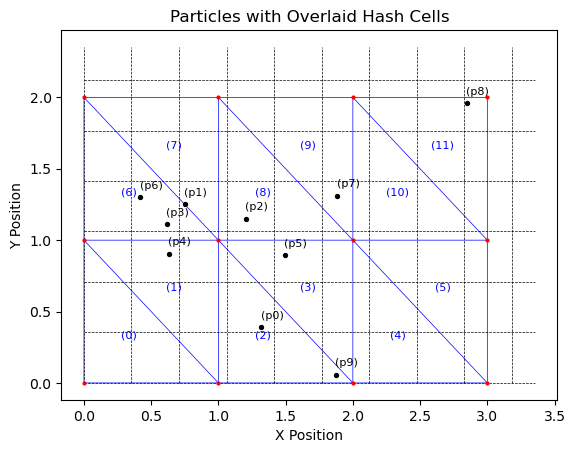

In [78]:
for k in range(num_particles):
    print(f"Particle {k} hash id, elements : {particle_hash_ids[k]} = {triangles_hashmap[particle_hash_ids[k]]}")

plot_particles_with_mesh_and_hash_cells(vertices,elements,xp,yp,hash_cell_size,annotate_particles=True,annotate_elements=True)

With each particle now having a list of possible elements they could reside in, we now need to develop a check for determining if a particle is inside or outside a triangle. Determining whether a particle is inside or outside a triangle can be done using **barycentric coordinates**. 

Barycentric coordinates provide a convenient way to express any point inside a triangle in terms of the triangle's vertices. The idea is to express a point $( P )$ as a combination of the vertices of the triangle $( A )$, $( B )$, and $( C )$.

Let the vertices of the triangle be:
- $( A = (x_A, y_A) )$
- $( B = (x_B, y_B) )$
- $( C = (x_C, y_C) )$

Given a point $( P = (x_P, y_P) )$, we can determine if it lies inside the triangle by solving for the barycentric coordinates $( \lambda_1, \lambda_2, \lambda_3 )$, such that:

$P = \lambda_1 A + \lambda_2 B + \lambda_3 C$

Geometrically, the value of each coordinate represents the proportional area of the sub-triangle formed by the point P and the opposite edge of the original triangle. If a point lies inside the triangle, all of its barycentric coordinates are between 0 and 1. Mathematically, we can write

$\lambda_1 = Area(BCP)/Area(ABC)$
$\lambda_1 = Area(CAP)/Area(ABC)$
$\lambda_3 = Area(ABP)/Area(ABC)$

The area of a triangle given only three points can be calculated as

$ A = 1/2 ( x_1(y_2-y_3) + x_2(y_3-y_1) + x_3(y_1-y_2))$

All of this is put together in the `barycentric_coordinates` function below, which takes a particle position and a triangular element's vertices and computes the barycentric coordinates. Additionally, it reports if the particle is inside or outside the triangle. 

Here, we'll just look at the first particle and the first element it is associated with to test this out. To get the particle position, we simply take `xp[0]` and `yp[0]`. To get the triangle vertices, we use the particle's hash cell id to obtain the list of triangular elements it may be associated with. We take the first element id from this list and use this to obtain the corresponding vertex ids. From the vertex ids, we obtain the `x` and `y` positions from the `vertices` array.

In [103]:
def barycentric_coordinates(xP, yP, triangle_vertices):
    """
    Compute the barycentric coordinates of a particle in a triangular element
    
    Parameters:
    - xP, yP: The coordinates of the particle
    - triangle_vertices (np.ndarray) : The vertices of the triangle as a (3,2) array.
    
    Returns:
    - The barycentric coordinates (l1,l2,l3)
    - True if the point is inside the triangle, False otherwise.
    """
    
    xv = np.squeeze(triangle_vertices[:,0])
    yv = np.squeeze(triangle_vertices[:,1])

    A_ABC = xv[0]*(yv[1]-yv[2]) + xv[1]*(yv[2]-yv[0]) + xv[2]*(yv[0]-yv[1])
    A_BCP = xv[1]*(yv[2]-yP   ) + xv[2]*(yP   -yv[1]) + xP   *(yv[1]-yv[2])
    A_CAP = xv[2]*(yv[0]-yP   ) + xv[0]*(yP   -yv[2]) + xP   *(yv[2]-yv[0])
    A_ABP = xv[0]*(yv[1]-yP   ) + xv[1]*(yP   -yv[0]) + xP   *(yv[0]-yv[1])

    # Compute the vectors
    l1 = A_BCP/A_ABC
    l2 = A_CAP/A_ABC
    l3 = A_ABP/A_ABC
    
    inside_triangle = all( [l1 >= 0.0, l1 <= 1.0, 
                            l2 >= 0.0, l2 <= 1.0,
                            l3 >= 0.0, l3 <= 1.0] )
    
    return l1,l2,l3,inside_triangle


# Example usage using the first particle
pid = 0
# Get the particle position
xP = xp[pid]
yP = yp[pid]

# Get the hash cell id for the particle
idx = particle_hash_ids[pid]

# Get the first possible element we want to check
eid = triangles_hashmap[idx][0]

# From the element, get the vertices
vertex_ids = elements[eid]
triangle_vertices = vertices[vertex_ids]

print(f"Particle position  : ({xP},{yP})")
print(f"Hash cell id       : {idx}")
print(f"Element id         : {eid}")
print(f"Vertex ids         : {vertex_ids}")
print(f"Triangle vertices  : {triangle_vertices[0],triangle_vertices[1],triangle_vertices[2],}")

# Get the barycentric coordinates
l1,l2,l3,is_inside = barycentric_coordinates(xP,yP,triangle_vertices)

print(f"Barycentric coords : ({l1},{l2},{l3})")
print(f"Is inside          : {is_inside}")


Particle position  : (1.3182667440290392,0.38852212923279406)
Hash cell id       : 12
Element id         : 2
Vertex ids         : [1 2 5]
Triangle vertices  : (array([1, 0]), array([2, 0]), array([1, 1]))
Barycentric coords : (0.29321112673816674,0.3182667440290392,0.38852212923279406)
Is inside          : True


In general, we want to associate each particle with a triangular element ID. This can be done by looping over the particles and repeating a process similar to what we did above. Instead of just looking at the first possible element obtained from the hash table, we could loop over the elements in the hash table until the particle is found inside the element.

For convenience, we plot the particles in the elements, without the hash cells below


Particle 0 element (coordinates): 2 (0.29321112673816674,0.3182667440290392,0.38852212923279406)
Particle 1 element (coordinates): 7 (0.7490139943336991,0.0023609086430361748,0.24862509702326474)
Particle 2 element (coordinates): 8 (0.6466405468905527,0.20219991734213294,0.15115953576731433)
Particle 3 element (coordinates): 6 (0.26804219939628515,0.6173570253246796,0.11460077527903523)
Particle 4 element (coordinates): 1 (0.09401636704201222,0.5377886153247796,0.36819501763320817)
Particle 5 element (coordinates): 3 (0.10390483726493294,0.3921777395859576,0.5039174231491095)
Particle 6 element (coordinates): 6 (0.27702689898915156,0.41928288181460527,0.30369021919624317)
Particle 7 element (coordinates): 9 (0.6883651629533443,0.1968423514536919,0.11479248559296384)
Particle 8 element (coordinates): 11 (0.040829789034442676,0.804478114037082,0.1546920969284753)
Particle 9 element (coordinates): 2 (0.07039454620616192,0.8717468496778871,0.05785860411595101)


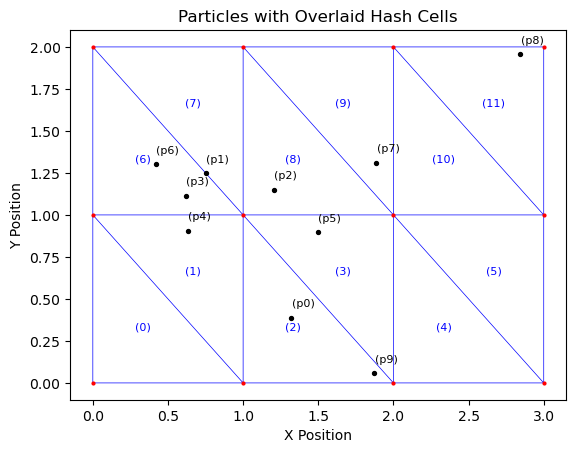

In [107]:
def get_particles_in_elements(xp, yp, vertices, elements, particle_hash, overlapping_triangles):
    """
    
    Parameters:
    - xp (np.ndarray): Array of x component of the particle positions (length = np)
    - yp (np.ndarray): Array of y component of the particle positions (length = np)
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - particle_hash (np.ndarray(dtype=int)): Array of size (np) that stores the hash cell index for the particles
    - overlapping_triangles (dict): A dictionary where keys are the hash cell index and values are lists of triangle indices.

    Returns:
    - particle_element (np.ndarray): Array that lists for each particle its associated element id (length = np)
    - particle_coordinates (np.ndarray) : Array of barycentric coordinates for each particle (np,3)
    """

    particle_element = np.zeros(xp.size,dtype=np.int32)
    particle_coordinates = np.zeros((xp.size,3))
    
    for k in range(xp.size):
        # Get the hash cell id for the particle
        idx = particle_hash_ids[k]
        
        # Find the first element in the hash table
        # that the particle is inside of
        for eid in triangles_hashmap[idx]:
        
            # From the element, get the vertices
            vertex_ids = elements[eid]
            triangle_vertices = vertices[vertex_ids]
        
            # Get the barycentric coordinates
            l1,l2,l3,is_inside = barycentric_coordinates(xp[k],yp[k],triangle_vertices)
            if is_inside:
                # If the particle is inside this element,
                # store the element id and the barycentric coordinates
                # and break from the eid loop
                particle_element[k] = eid
                particle_coordinates[k,:] = [l1,l2,l3]
                break

    return particle_element, particle_coordinates

# Testing below
p_elems, p_coords = get_particles_in_elements(xp,yp,vertices,elements,particle_hash_ids,triangles_hashmap)

for k in range(xp.size):
    print(f"Particle {k} element (coordinates): {p_elems[k]} ({p_coords[k,0]},{p_coords[k,1]},{p_coords[k,2]})")

plot_particles_with_mesh_and_hash_cells(vertices,elements,xp,yp,hash_cell_size,plot_hash_cells=False,annotate_particles=True,annotate_elements=True)